# Photon ID Run 2 BDT classification

In [1]:
import numpy as np
import pandas as pd
import pickle
import joblib

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

In [2]:
datadir = "/home/chardong/y_identification/Venv/save_pkl/"
savedir = "/home/chardong/y_identification/Venv/save_plots/Py8_yj_jj_train_skim30/"

#datadir = "/eos/user/m/mdelmast/Data/EGamma/PhotonID/Run2/"

In [3]:
#df = pd.read_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w.pkl")
#df = pd.read_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w_skim.pkl")
#df = pd.read_pickle(datadir+"Py8_yj_jj_mc16ade_pd122_train_w_skim_50.pkl")
df = pd.read_pickle(datadir+"RAW_data/Py8_yj_jj_mc16ade_pd122_train_w_skim_30.pkl")

In [4]:
df.head()

,y_Reta,y_Rphi,y_weta2,y_fracs1,y_weta1,y_wtots1,y_Rhad,y_Rhad1,y_Eratio,y_deltae,...,y_pt,y_eta,y_phi,evt_mu,y_IsTight,y_IsLoose,y_truth_pt,y_truth_eta,weight,truth_label
32567178,0.976772,0.986029,0.008603,0.215509,0.574328,2.513235,0.003049,0.003494,0.885819,5.736908,...,142.612122,0.635589,2.903673,46.5,True,True,140.036636,0.635112,3.236591,1.0
30571405,0.953056,0.965354,0.009983,0.281922,0.663873,2.277502,-0.000054,-0.000830,0.993126,36.003273,...,147.476898,1.265382,-1.025224,43.5,True,True,150.216537,1.265649,3.840031,1.0
12717653,0.957415,0.779845,0.009942,0.299277,0.611491,2.026455,0.000606,-0.000677,0.960725,61.969635,...,57.505829,-0.752667,-2.275640,22.5,True,True,56.256836,-0.753302,148.330020,1.0
34705749,0.956207,0.957556,0.010389,0.280299,0.646524,2.207805,-0.000503,0.002520,0.993375,166.006592,...,310.122559,1.650223,-0.126305,31.5,True,True,318.032928,1.649813,0.327451,1.0
33543598,0.963815,0.983650,0.009125,0.183293,0.555536,2.020921,0.001133,0.000105,0.973434,37.050293,...,285.942383,-0.579351,-0.296943,34.5,True,True,283.473541,-0.579254,0.225641,1.0


### Prepare inputs for training

* `discriminating_var` containes the features used in the training
* Weights are added Y column to be able to access them after splitting in train and test samples.
* `test_size` represents the proportion of the dataset to include in the test split

In [5]:
shower_shape_var = ['y_Reta',
                    'y_Rphi',
                    'y_weta2',
                    'y_fracs1',
                    'y_weta1',
                    'y_wtots1',
                    'y_Rhad',
                    'y_Rhad1',
                    'y_Eratio', 
                    'y_deltae']

conv_var = [ 'y_convRadius', 'y_convType']

kinem_var = ['y_pt', 'y_eta', 'y_phi']

truth_var = ['y_truth_pt', 'y_truth_eta' ]

discriminating_var = shower_shape_var + kinem_var + conv_var 

Y_var = list(set(df.columns)-set(discriminating_var+truth_var))
Y_var

['y_IsLoose', 'y_IsTight', 'truth_label', 'weight', 'evt_mu']

### Draw shower shape distributions (example, inclusive)

(Modify to plot all shower shapes, and also as function of convertions status and in bins of $\eta$ and $\p_T$ )

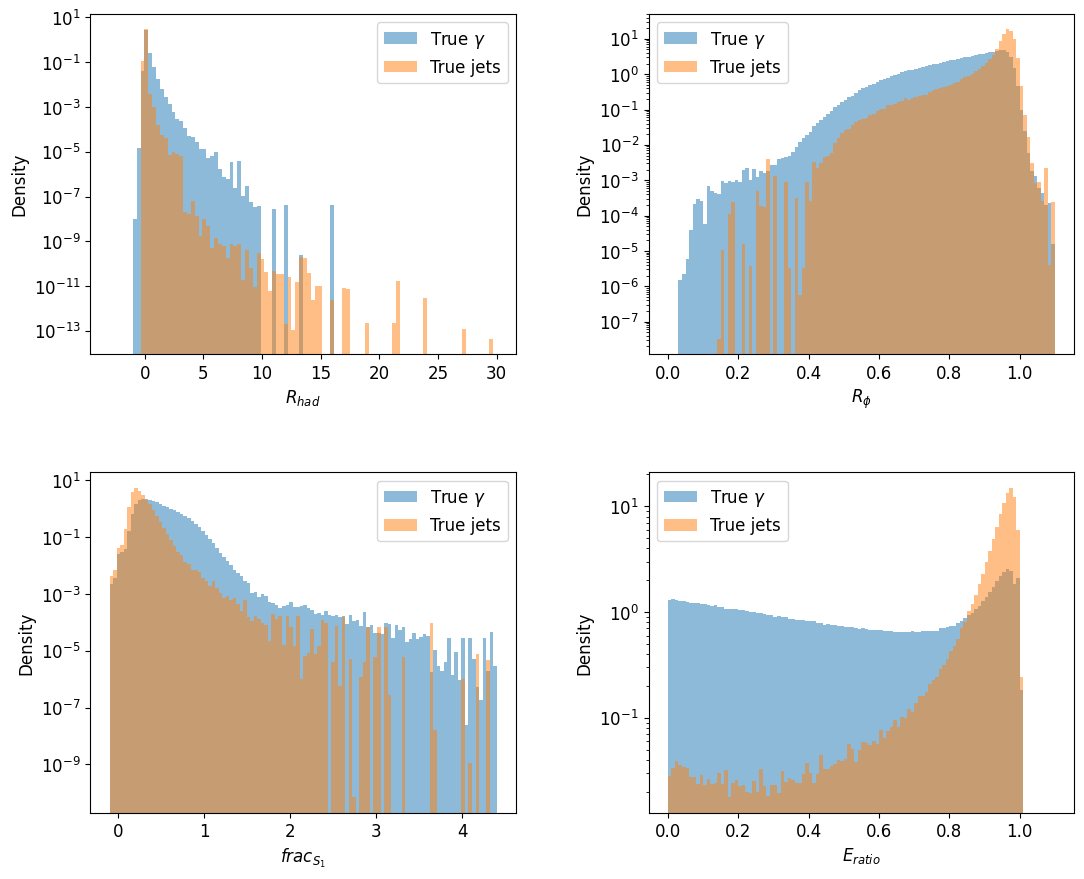

In [6]:
plt.rcParams.update({'font.size': 12})

fig, axes = plt.subplots(2, 2, figsize = (12, 10))
fig.tight_layout(pad = 5.0)

def plotShowerShapeInclusive(ax,df,var='y_Rhad',varname=r'$R_{had}$',vmin=0,vmax=1,nbins=100):
    bins = [vmin+d*(vmax-vmin)/nbins for d in range(nbins+1)]
    _ = ax.hist( df[(df["truth_label"]==0)][var], weights=df[(df["truth_label"]==0)]['weight'], 
                histtype='stepfilled', bins=bins, log=True, density=True, alpha=0.5,
                label = r'True $\gamma$')
    _ = ax.hist( df[(df["truth_label"]==1)][var], weights=df[(df["truth_label"]==1)]['weight'], 
                histtype='stepfilled', bins=bins, log=True, density=True, alpha=0.5, 
                label = r'True jets')
    ax.set_xlabel(varname)
    ax.set_ylabel("Density")
    ax.legend()

plotShowerShapeInclusive(axes[0][0], df, var='y_Rhad'  , varname=r'$R_{had}$'   , vmin=-3  ,vmax=30 , nbins=100)
plotShowerShapeInclusive(axes[0][1], df, var='y_Rphi'  , varname=r'$R_{\phi}$'  , vmin=0   ,vmax=1.1, nbins=110)
plotShowerShapeInclusive(axes[1][0], df, var='y_fracs1', varname=r'$frac_{S_1}$', vmin=-0.1,vmax=4.4, nbins=110)
plotShowerShapeInclusive(axes[1][1], df, var='y_Eratio', varname=r'$E_{ratio}$' , vmin=0   ,vmax=1.1, nbins=110)

plt.savefig(savedir+'shower_shape.pdf')

### Save X and Y datasets with relevant variables

* Adding truth variables to X for performance studies, will be removed after splitting

In [7]:
X = df[discriminating_var+truth_var]
Y = df[Y_var]

### Split dataset into train, validation and test samples

* Test dataset size: 20 %

In [8]:
x_train_val, x_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

### Split train + validation set into train and validation

* Train and validation are respectively 80% and 20% of 80% of total
* Save weights in separate arrays

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, random_state=42)

In [10]:
weight_train = y_train["weight"]
weight_val   = y_val  ["weight"]
weight_test  = y_test ["weight"]

In [11]:
Y_var_drop = list(set(Y_var)-{"truth_label"})

othervars_train = y_train[Y_var_drop]
othervars_val   = y_val  [Y_var_drop]
othervars_test  = y_test [Y_var_drop]

y_train = y_train.drop(Y_var_drop, axis=1)
y_test  = y_test .drop(Y_var_drop, axis=1)
y_val   = y_val  .drop(Y_var_drop, axis=1)

In [12]:
truth_train = x_train[truth_var]
truth_val   = x_val  [truth_var]
truth_test  = x_test [truth_var]

x_train = x_train.drop(truth_var, axis=1)
x_test  = x_test .drop(truth_var, axis=1)
x_val   = x_val  .drop(truth_var, axis=1)

In [13]:
print('TRAINING   size = {:8d}'.format(len(y_train)))
print('TEST       size = {:8d}'.format(len(y_test)))
print('VALIDATION size = {:8d}'.format(len(y_val)))

TRAINING   size = 11182003
TEST       size =  3494377
VALIDATION size =  2795501


In [14]:
print('Number of signal events in test sample     :', len(y_test.query('truth_label == True')))
print('Number of background events in test sample :', len(y_test.query('truth_label == False')))

Number of signal events in test sample     : 2338410
Number of background events in test sample : 1155967


In [15]:
y_train = np.ravel(y_train)
y_val   = np.ravel(y_val)

### BDT training

In [16]:
model = lgb.LGBMClassifier(learning_rate  = 0.05,  
                           num_leaves     = 35,
                           max_depth      = -5,
                           objective      = 'xentropy',
                           n_estimators   = 1000,
                           force_col_wise = True)

cb = [lgb.early_stopping(stopping_rounds=10),lgb.log_evaluation(30)]

In [ ]:
model.fit(x_train, y_train,
          sample_weight = weight_train,
          eval_set = [(x_train, y_train), (x_val, y_val)],  
          eval_names = ['Train', 'Validation'],
          eval_metric = 'xentropy', 
          eval_sample_weight = [weight_train, weight_val],
          callbacks=cb)

In [ ]:
# Saving model to file
#joblib.dump(model,'models/LGBMClassifier_model_hard_no_loose_lr0.05_35_skim50.pkl')
joblib.dump(model,'models/LGBMClassifier_model_hard_no_loose_lr0.05_35_skim30.pkl')

In [ ]:
# Loading model from file
#model = joblib.load('models/LGBMClassifier_model_hard_no_loose_lr0.05_35_skim50.pkl')
model = joblib.load('models/LGBMClassifier_model_hard_no_loose_lr0.05_35_skim30.pkl')

### Feature importance

In [ ]:
# Cross-entropy evolution during training
lgb.plot_metric(model, figsize=(8,6))
plt.title('Metric during training')

#plt.savefig('plots/metric_lr_0.09_35_skim50.pdf')
plt.savefig('plots/metric_lr_0.09_35_skim30.pdf')
plt.show()

In [ ]:
# Feature importance: Numbers of times the feature is used in a model
lgb.plot_importance(model, importance_type='split', figsize=(8,6))
plt.title('Feature importance: split')

#plt.savefig('plots/feature_split_lr_0.09_35_skim50.pdf')
plt.savefig('plots/feature_split_lr_0.09_35_skim30.pdf')
plt.show()

In [ ]:
lgb.plot_importance(model, importance_type='gain', precision = None, figsize=(8,6))
plt.title('Feature importance: gain')

#plt.savefig('plots/feature_gain_lr_0.09_35_skim50.pdf')
plt.savefig('plots/feature_gain_lr_0.09_35_skim30.pdf')
plt.show()

### Make predictions for test sample, add signal and background scores

In [ ]:
y_pred_prob_test = model.predict_proba(x_test)

df_pred_test = pd.DataFrame(y_pred_prob_test, columns=["background_score", "signal_score"])
df_pred_test.reset_index(inplace=True, drop=True)

In [ ]:
y_test = pd.DataFrame(y_test)
y_test.reset_index(inplace=True, drop=True)

truth_test.reset_index(inplace=True, drop=True)

othervars_test.reset_index(inplace=True, drop=True)

df_test_vars = x_test[kinem_var + conv_var]
df_test_vars.reset_index(inplace=True, drop=True)

weight_test = pd.DataFrame(weight_test)
weight_test.reset_index(inplace=True, drop=True)

In [ ]:
df_test = pd.concat([df_test_vars,
                     weight_test,
                     y_test,
                     othervars_test,
                     truth_test,
                     df_pred_test,
                    ], axis=1, join='inner', ignore_index=True)

In [ ]:
col_names = list(df_test_vars.columns) + \
            list(weight_test.columns) + \
            list(y_test.columns) + \
            list(othervars_test.columns) + \
            list(truth_test.columns) + \
            list(df_pred_test.columns)
df_test.columns = col_names

In [ ]:
df_test

In [ ]:
#df_test.to_pickle(datadir+"test_sample_hard_scattering_skim50.pkl")
df_test.to_pickle(datadir+"test_sample_hard_scattering_skim30.pkl")

### BDT output

The BDT output has two columns: for each event a score (probability) to belong to class 0 or class 1  (here they are called `background_class` and `signal_class` ) is assigned.

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

plt.hist(df_test[(df_test["truth_label"]==0 )]["signal_score"],
         weights = df_test[(df_test["truth_label"]==0 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5, 
         histtype = 'stepfilled', label='Background', color = 'b')

plt.hist(df_test[(df_test["truth_label"]==1 )]["signal_score"],
         weights = df_test[(df_test["truth_label"]==1 )]["weight"], 
         bins = 50, log = True, density = True, alpha=0.5,
         histtype = 'stepfilled', label='Signal', color = 'orange')

plt.ylabel('Frequency', fontsize = 14)

plt.legend(loc='upper center', fontsize = 14)
plt.gca().set(xlabel="LightGBM score (probability to be assigned to the signal class)")

#plt.savefig('plots/score_lr_0.09_35_skim50.pdf')
plt.savefig('plots/score_lr_0.09_35_skim30.pdf')
plt.show()

### ROC curve

1) compute signal and background efficiencies for "official" cut-based Tight selection

In [ ]:
s_tot = sum( df_test[(df_test["truth_label"] == 1)]["weight"] )
s_selected = sum( df_test[(df_test["truth_label"] == 1) & (df_test['y_IsTight'].values)]["weight"] )
s_eff = s_selected / s_tot

b_tot = sum( df_test[(df_test["truth_label"] == 0)]["weight"] )
b_selected = sum( df_test[(df_test["truth_label"] == 0) & (df_test['y_IsTight'].values)]["weight"] )
b_eff = b_selected / b_tot

In [ ]:
print(f"Number of signal events                   = {s_tot:12.0f}")
print(f"Number of signal events passing Tight     = {s_selected:12.0f}")
print(f"Signal efficiency of cut-based Tight      = {100.*s_selected/s_tot:11.2f}%" )
print()
print(f"Number of background events               = {b_tot:12.0f}")
print(f"Number of background events passing Tight = {b_selected:12.0f}")
print(f"Background efficiency of cut-based Tight  = {100.*b_selected/b_tot:11.2f}%" )
print(f"Background rejection of cut-based Tight   = {100.*(1-b_selected/b_tot):11.2f}%" )

2) Plot ROC curve of trained BDT with weighted events, compare to current cut-based Tight selection 

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

mod_disp = RocCurveDisplay.from_estimator(model, x_test, y_test, sample_weight=weight_test, 
                                          label="BDT", ax=ax) 

plt.plot(b_eff, s_eff, marker="x", markersize=10, color="red", label = 'Cut-based Tight ID')

plt.xlabel('Background efficiency')
plt.ylabel('Signal efficiency')

#plt.xlim([0.0, 0.15])
#plt.ylim([0.65, 1.0])
#plt.title('BDT ROC curve - zoom')

plt.title('BDT ROC curve')
plt.legend()

plt.savefig('plots/ROC_lr_0.05_35_weight_skim50.pdf')
plt.show()

### Correlation between input variables

In [ ]:
#x_train_sel = x_train.query('y_wtots1 >- 800 & y_weta1 > -800')
#x_train_sel.reset_index(inplace=True, drop=True)

In [ ]:
corr = x_train.corr()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.rcParams.update({'font.size': 10})

sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", ax=ax, annot=True, fmt=".2f")

plt.tight_layout()
plt.savefig('plots/correlations_train_sample_all.pdf')
plt.show()

In [ ]:
#corr_sig = x_train[(y_train==1)].corr()
#corr_bkg = x_train[(y_train==0)].corr()